In [1]:
import torch
import numpy as np
from torch import optim
import os
import matplotlib.pyplot as plt

In [2]:
from dlem import util
from dlem import load_model, load_reader

In [3]:
NUMBER_OF_CHANNELS_PER_ROUTE = 3

In [4]:
BATCH_SIZE = 5 
DATA_FOLDER = "../../../loopextrusion_data_creation/.data/training_data_res_1000_patch_size_500"#".data/dlem_training"
TEST_FOLD = 'fold4'
VAL_FOLD = 'fold5'
LEARNING_RATE = 0.0001
PATIENCE = 25
NUM_EPOCH = 250
SAVE_FOLDER = f"{NUMBER_OF_CHANNELS_PER_ROUTE}_per_route_res_1000_seq"
GENOME_FILE = "/data/genomes/human/Homo_sapiens/UCSC/hg38/Sequence/WholeGenomeFasta/genome.fa"

In [5]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
data = load_reader("datareader_w_seq")(DATA_FOLDER, GENOME_FILE, sub_select=np.array([0, 1])) # Selecting ctcf and dnase

2024-10-03 16:24:29.399420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 16:24:29.415708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 16:24:29.420802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 16:24:29.432732: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 16:24:30.162878: W tensorflow/compiler/tf2

In [7]:
def weighted_mse(pred, target):
    return torch.mean((pred - target)**2*torch.exp(target))

In [8]:
weighted_mse(torch.from_numpy(data[0][0]), torch.from_numpy(data[1][0]))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


tensor(0.5583)

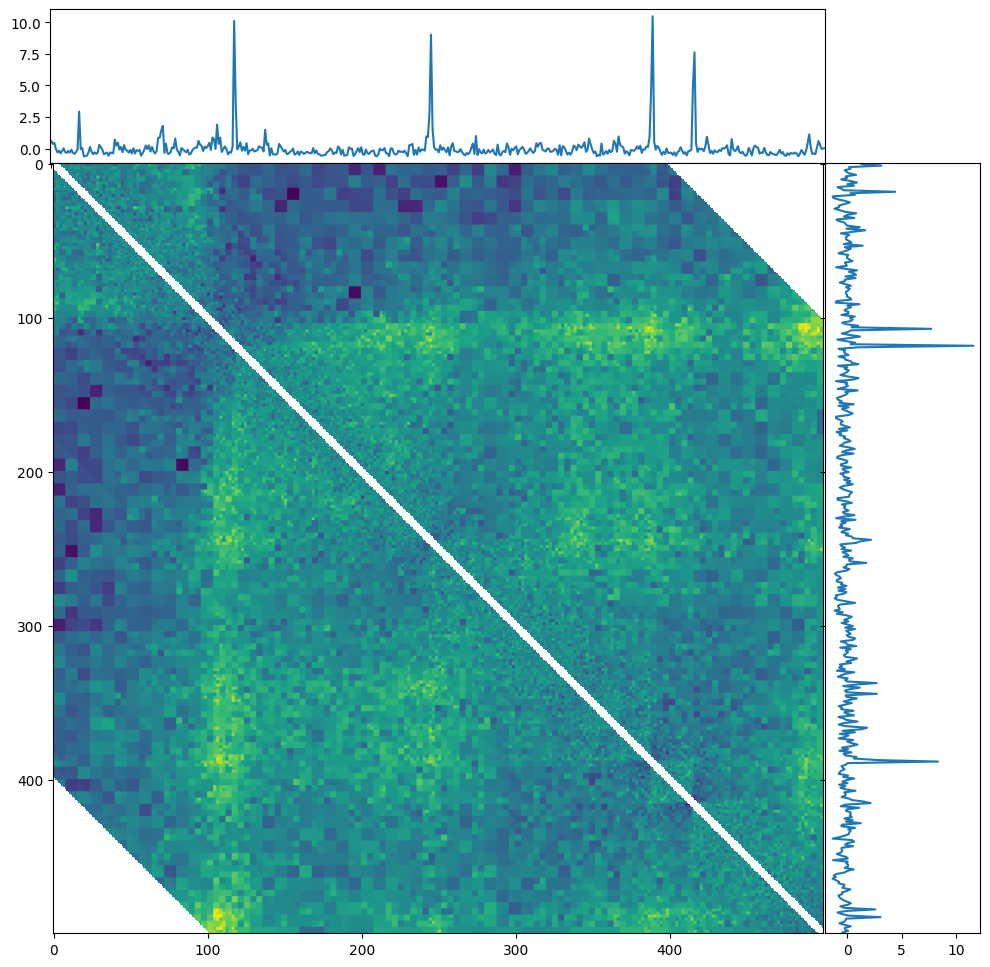

In [9]:
patch = util.convert_diags_to_full_contact(data[0][0], data.start_diag, data.stop_diag)
util.plot_results(patch,
                  patch,
                  (data[0][1][0],
                   data[0][1][1]),
                   ignore_i=data.start_diag,
                   ignore_i_off=data.stop_diag)

In [10]:
data_test = torch.utils.data.Subset(data, np.where(data.data_folds == TEST_FOLD)[0])
data_val = torch.utils.data.Subset(data, np.where(data.data_folds == VAL_FOLD)[0])
data_train = torch.utils.data.Subset(data, np.where(np.logical_and(data.data_folds != VAL_FOLD,
                                                                   data.data_folds != TEST_FOLD))[0])

In [11]:
data_train = torch.utils.data.Subset(data, np.arange(500))

In [12]:
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size = BATCH_SIZE, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size = BATCH_SIZE, shuffle=True)
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size = BATCH_SIZE, shuffle=True)

In [13]:
index_diagonal = util.diag_index_for_mat(data.patch_dim, data.start_diag, data.stop_diag)

In [14]:
model = load_model("encodetocontact_forked_seq")(data.patch_dim,
                                                      data.feature_dim,
                                                      data.start_diag,
                                                      data.stop_diag,
                                                      seq_fea_dim=10,
                                                      channel_per_route=NUMBER_OF_CHANNELS_PER_ROUTE)
model = model.to(dev)

In [15]:
model

DLEM(
  (seq_pooler): SequencePooler(
    (pooler): Sequential(
      (0): Conv1d(4, 16, kernel_size=(5,), stride=(10,), dilation=(2,))
      (1): ReLU()
      (2): Conv1d(16, 16, kernel_size=(5,), stride=(10,), dilation=(2,))
      (3): ReLU()
      (4): Conv1d(16, 10, kernel_size=(5,), stride=(10,), dilation=(2,))
      (5): ReLU()
    )
  )
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(9, 9, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(6, 6, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (trans_convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (mixer): Sequential(
    (0): Conv1d(12, 2, kernel_size=(1,), stride=(1,))


In [14]:
if not os.path.exists(os.path.join(DATA_FOLDER, SAVE_FOLDER)):
    os.mkdir(os.path.join(DATA_FOLDER, SAVE_FOLDER))

In [15]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, mode='max')
loss = torch.nn.MSELoss(reduction='mean')

In [29]:
diag_init = torch.from_numpy(np.ones((BATCH_SIZE, data.patch_dim), dtype=np.float32) * data.patch_dim)

In [17]:
lr_threshold = 1.5e-6

In [18]:
data[0][2].shape

torch.Size([4, 500000])

In [19]:
best_loss = torch.inf
best_corr = -1
mean_loss_traj_train = []
mean_corr_traj_val = []
model = model.to(dev)
diag_init = diag_init.to(dev)
for e in range(NUM_EPOCH):
    training_loss = []
    validation_corr = []
    model.train()
    for diagonals, tracks, seq in dataloader_train:
        optimizer.zero_grad()
        tracks = tracks.to(dev)
        diagonals = diagonals.to(dev)
        seq = seq.to(dev)
        total_loss = 0
        for diag_i in range(data.start_diag, data.stop_diag-1):
            next_diag = model(tracks, torch.exp(diagonals[:, index_diagonal(diag_i)]), seq, diag_i)
            total_loss += loss(next_diag, diagonals[:, index_diagonal(diag_i+1)])
        total_loss.backward()
        optimizer.step()
        training_loss.append(total_loss.detach().cpu().numpy())

    mean_total_loss = np.mean(training_loss)
    mean_loss_traj_train.append(mean_total_loss)

    if mean_total_loss < best_loss:
        best_loss = mean_total_loss
        #best_loss_model = copy.deepcopy(model)
        torch.save(model.state_dict(),
                   os.path.join(DATA_FOLDER, SAVE_FOLDER, "best_loss.pt"))

    with torch.no_grad():
        model.eval()

        for diagonals, tracks, seq in dataloader_val:
            tracks = tracks.to(dev)
            diagonals = diagonals.to(dev)
            seq = seq.to(dev)
            out = model.contact_map_prediction(tracks, seq, diag_init[:tracks.shape[0]])
            validation_corr.append(util.mat_corr(diagonals, out).detach().cpu().numpy())

        mean_corr = np.mean(validation_corr)
        mean_corr_traj_val.append(mean_corr)

    if mean_corr > best_corr:
        best_corr = mean_corr
        #best_corr_model = copy.deepcopy(model)
        torch.save(model.state_dict(),
                   os.path.join(DATA_FOLDER, SAVE_FOLDER, "best_correlation.pt"))

    scheduler.step(mean_corr)
    if scheduler.get_last_lr()[-1] < lr_threshold:
        break

    print(f'{int((e+1)/NUM_EPOCH*100):3}/100: '
            f'correlation = {mean_corr:.3f}, '
            f'loss = {mean_total_loss:.3f}',
            flush=True, end='\r')

KeyboardInterrupt: 

In [20]:
scheduler.get_last_lr()

[0.0001]

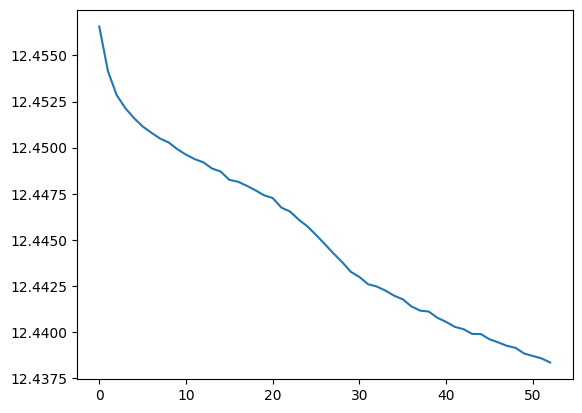

In [21]:
plt.plot(mean_loss_traj_train)

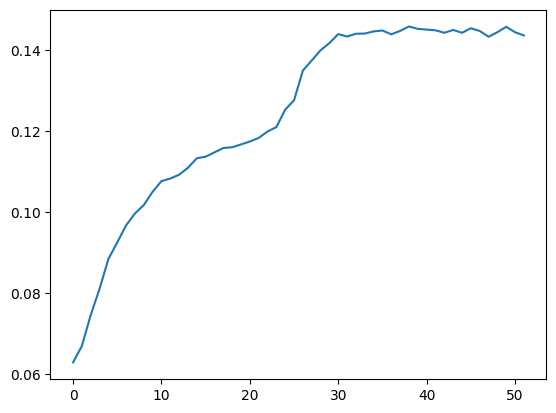

In [22]:
plt.plot(mean_corr_traj_val)